<a href="https://colab.research.google.com/github/joshfpedro/math-328/blob/main/least_squares_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def least_squares_polynomial(x_data, y_data, degree):
    """
    Fit polynomial using least squares.

    Parameters
    ----------
    x_data : array
        x-coordinates of data
    y_data : array
        y-coordinates of data
    degree : int
        Degree of polynomial to fit

    Returns
    -------
    coefficients : array
        Polynomial coefficients [a_0, a_1, ..., a_m]
    """
    # Build Vandermonde matrix
    A = np.vander(x_data, degree + 1, increasing=True)

    # Solve normal equations: A^T A a = A^T y
    coeffs = np.linalg.solve(A.T @ A, A.T @ y_data)

    return coeffs

# Generate noisy data
np.random.seed(42)
x_data = np.linspace(0, 10, 20)
y_true_data = 2 + 0.5 * x_data - 0.05 * x_data**2
y_noisy = y_true_data + np.random.normal(0, 1.0, len(x_data))

# Test it
coeffs = least_squares_polynomial(x_data, y_noisy, 3)
print(f"Fitted polynomial: y = {coeffs[0]:.3f} + {coeffs[1]:.3f}x + {coeffs[2]:.3f}x²")
print(f"True polynomial:   y = 2.000 + 0.500x - 0.050x²")

Fitted polynomial: y = 2.239 + 0.972x + -0.209x²
True polynomial:   y = 2.000 + 0.500x - 0.050x²


## Polynomial Regression

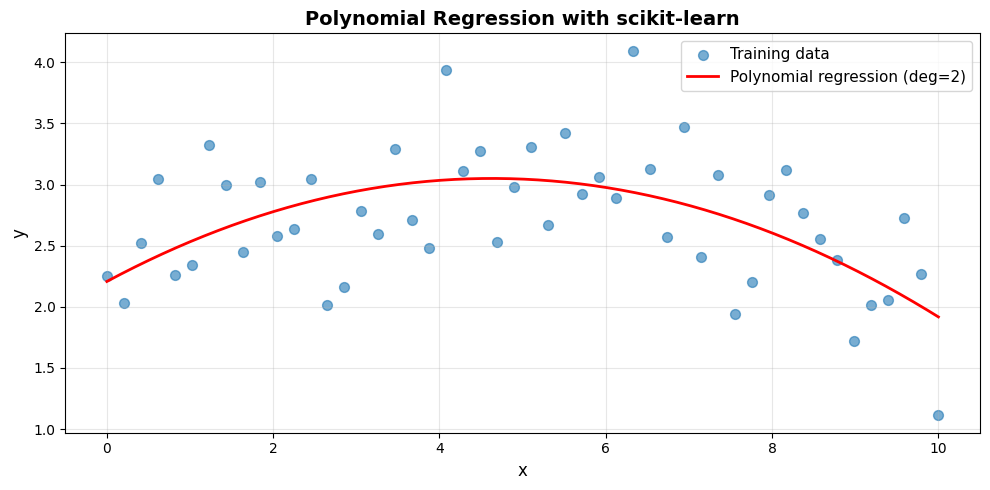

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Generate data
np.random.seed(42)
X = np.linspace(0, 10, 50).reshape(-1, 1)
y = 2 + 0.5 * X.ravel() - 0.05 * X.ravel()**2 + np.random.normal(0, 0.5, 50)

# Fit polynomial regression (degree 2)
model = make_pipeline(PolynomialFeatures(2), LinearRegression())
model.fit(X, y)

# Predict
X_test = np.linspace(0, 10, 300).reshape(-1, 1)
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, alpha=0.6, s=50, label='Training data')
plt.plot(X_test, y_pred, 'r-', linewidth=2, label='Polynomial regression (deg=2)')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Polynomial Regression with scikit-learn', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Cross Validation

### Generate Training and Test Data

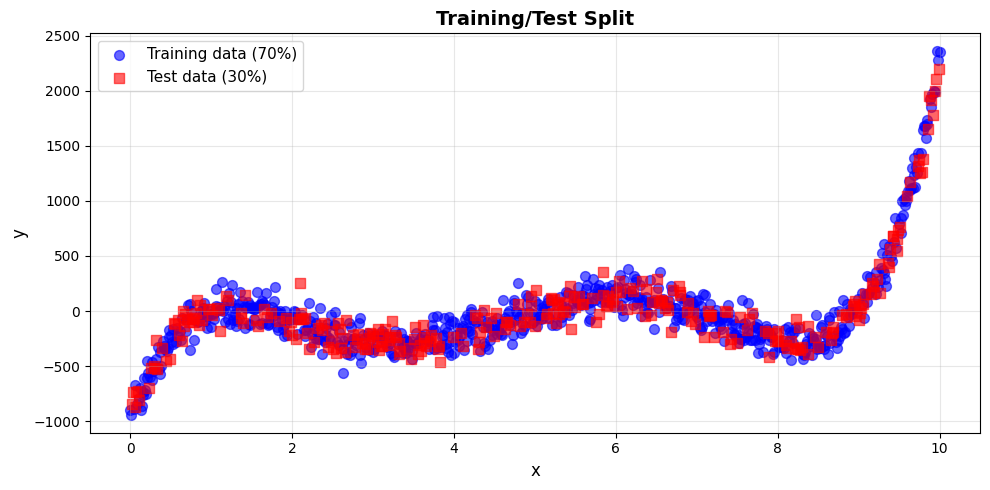

In [56]:
from sklearn.model_selection import train_test_split

# Generate larger dataset
np.random.seed(42)
X_full = np.linspace(0, 10, 1000).reshape(-1, 1)
y_full = (X_full.ravel() - 1) * (2*X_full.ravel() - 3) * (X_full.ravel() - 5) * (X_full.ravel() - 7) * (X_full.ravel() - 9) + np.random.normal(0, 100, 1000)

# Split: 70% training, 30% test
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Visualize the split
plt.figure(figsize=(10, 5))
plt.scatter(X_train, y_train, alpha=0.6, s=50, label='Training data (70%)', color='blue')
plt.scatter(X_test, y_test, alpha=0.6, s=50, label='Test data (30%)', color='red', marker='s')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Training/Test Split', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score

# Fit degree 3 polynomial with 5-fold CV
model = make_pipeline(PolynomialFeatures(3), LinearRegression())

# This automatically does 5 train/test iterations
cv_scores = cross_val_score(model, X_full, y_full, cv=5,
                            scoring='neg_mean_squared_error')

# Convert to positive MSE
cv_scores_pos = -cv_scores

print("="*60)
print("5-Fold Cross-Validation Results (Degree 3 Polynomial)")
print("="*60)
for i, score in enumerate(cv_scores_pos):
    print(f"Fold {i+1}: MSE = {score:.4f}")
print("-"*60)
print(f"Mean CV Score: {cv_scores_pos.mean():.4f} ± {cv_scores_pos.std():.4f}")
print("="*60)

5-Fold Cross-Validation Results (Degree 3 Polynomial)
Fold 1: MSE = 0.2475
Fold 2: MSE = 0.2404
Fold 3: MSE = 0.1680
Fold 4: MSE = 0.3133
Fold 5: MSE = 0.8367
------------------------------------------------------------
Mean CV Score: 0.3612 ± 0.2422


## Using CV for Model Selection

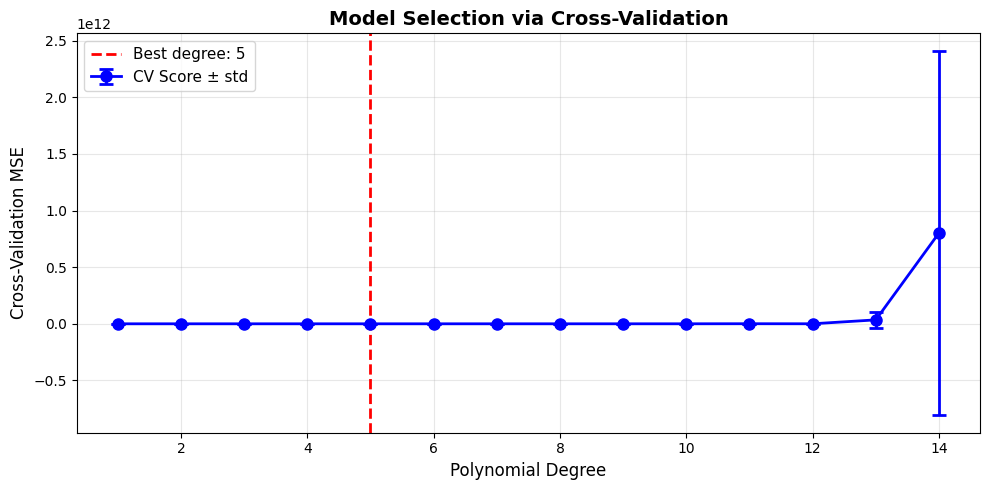

In [60]:
from sklearn.model_selection import cross_val_score

degrees = range(1, 15)
cv_scores = []
cv_stds = []

for deg in degrees:
    model = make_pipeline(PolynomialFeatures(deg), LinearRegression())
    # 5-fold cross-validation
    scores = cross_val_score(model, X_full, y_full, cv=5,
                             scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())  # Convert to positive MSE
    cv_stds.append(scores.std())

cv_scores = np.array(cv_scores)
cv_stds = np.array(cv_stds)

plt.figure(figsize=(10, 5))
plt.errorbar(degrees, cv_scores, yerr=cv_stds, fmt='bo-', linewidth=2,
             markersize=8, capsize=5, capthick=2, label='CV Score ± std')
plt.axvline(x=degrees[np.argmin(cv_scores)], color='r', linestyle='--',
            linewidth=2, label=f'Best degree: {degrees[np.argmin(cv_scores)]}')
plt.xlabel('Polynomial Degree', fontsize=12)
plt.ylabel('Cross-Validation MSE', fontsize=12)
plt.title('Model Selection via Cross-Validation', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()